# First data processing steps

In [2]:
import pandas as pd
import json
from ast import literal_eval
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import json

In [3]:
# read in the dataset 
# Some duplication happens, along with NAN values being filled 
df = pd.read_json('animal_news_database.json', lines = True)

# Add new column for storing the values article amount found under each species type 
df['article_amt'] = df['articles'].str.len()

In [4]:
print("Total amount of articles in the dataset:", df['article_amt'].sum())

Total amount of articles in the dataset: 15088


In [22]:
## Investigate the content of articles shared on Twitter

tweets = df[df.scientific_name.str.contains('@') == True]
t = tweets['articles'].map(dict.values).explode()
t = s.dropna()
# Drop the column articles and join the exploded values to the dataframe
tweets_full = tweets.drop(columns=['articles']).join(pd.DataFrame([*s], s.index))
tweets_full = tweets_full.drop(['_id'], axis=1)
tweets_full = tweets_full.reset_index(drop=True)

# Save Twitter data as CSV
tweets_full.to_csv("csv/twitter_articles.csv", sep = ";", index = False)

In [5]:
# Drop Twitter handles as they are not species names
df = df[df.scientific_name.str.contains('@') == False]
df.reset_index(drop = True, inplace = True)
# What is the total amount of articles after dropping Twitter tags
print("The amount of articles in the datset:", df['article_amt'].sum())
# How many species in the dataset 
species1 = df['scientific_name'].unique()
print("The amount of species in the datset:", len(species1))

In [7]:
# Read in the CITES data to join with the top 10 (or 20) most reported on species 
cites1 = pd.read_csv("csv/cites1.csv", delimiter = ';')
# Keep only most relevant columns
cites1 = cites1[['Kingdom', 'Class', 'Order', 'Family', 'Genus', 
                 'Species', 'Scientific Name', 'Listing', 
                 'NativeDistributionFullNames', 'Extinct_Distribution']]
# Rename for merging purposes
cites1 = cites1.rename(columns = {'Scientific Name' : 'scientific_name'})

print("The amount of species in CITES, Appendix 1: ", cites1['scientific_name'].nunique())

The amount of species in CITES, Appendix 1:  1130


In [8]:
# Merge the dataset with articles with the full CITES dataframe
df = df.merge(cites1, on = 'scientific_name', how = 'inner')
# Drop uneccessary id column
df = df.drop(['_id'], axis=1)
# Store another variable with new unique species, to investigate which species is being left out
species2 = df['scientific_name'].unique()


print("The species left behind after CITES data join:", list(set(species1) - set(species2)))
print("The amount of articles in the datset:", df['article_amt'].sum()) 
print("The number of species in the dataset:", df['scientific_name'].nunique())

The species left behind after CITES data join: ['Muntiacus vuquanghensis']
The amount of articles in the datset: 13855
The number of species in the dataset: 584


In [9]:
# Explode the articles column
s = df['articles'].map(dict.values).explode()
# NaN values need to be droppped
s = s.dropna()
# Drop the column articles and join the exploded values to the dataframe
df_full = df.drop(columns=['articles']).join(pd.DataFrame([*s], s.index))
# Print amount of unique species/text pairings, duplication likely happened in merge with CITES dataframe
print("The amount of unique species articles in the dataset: ", len(df_full.drop_duplicates(subset=['scientific_name','text'])))
species3 = df_full['scientific_name'].unique()
print("The amount of species in the dataset:", len(species3))

The amount of unique species articles in the dataset:  13360
The amount of species in the dataset: 584


In [10]:
# Displaying unique links in dataframe to run through sharedcount API
print("The amount of unique links in the dataframe:", df_full['link'].nunique())
# df_full['link'].nunique().to_csv("unique_links.csv", sep = ";")

The amount of unique links in the dataframe: 13551


In [120]:
# Processing for articles       
# keep only unique article instances of each species!
df_media = df_full.drop_duplicates(subset=['scientific_name','text'])
# Transform date column into DateTime
df_media["date"] = pd.to_datetime(df_media['date'])
# Sort by oldest to newest
df_media = df_media.sort_values(by="date")
# Drop article amt column, unneccessary 
df_media = df_media.drop(columns=['article_amt'])
# reset index
df_media.reset_index(drop = True, inplace = True)
# Remove any rows with blank data for the text column (empty articles)
df_media = df_media[df_media['text'].notna()]

print("The amount of articles in the dataset:",len(df_media))
print("The amount of species left: ",df_media['scientific_name'].nunique())

The amount of articles in the dataset: 13066
The amount of species left:  565


/tmp/ipykernel_72/2303875339.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [126]:
# Store this version so that all text can be analysed for locations + content, just not Facebook engangement stats
df_media.to_csv("articles_no_engagement.csv", sep = ";", index = False)

In [23]:
df_test = df_full.drop_duplicates(subset=['scientific_name','link'])
# Transform date column into DateTime
df_test["date"] = pd.to_datetime(df_test['date'])
# Sort by oldest to newest
df_test = df_test.sort_values(by="date")
# Drop article amt column, unneccessary 
df_test = df_test.drop(columns=['article_amt'])
# reset index
df_test.reset_index(drop = True, inplace = True)
# Remove any rows with blank data for the text column (empty articles)
df_test = df_test[df_test['text'].notna()]

print("The amount of articles in the dataset:",len(df_test))
print("The amount of species left: ",df_test['scientific_name'].nunique())

The amount of articles in the dataset: 13551
The amount of species left:  565


/tmp/ipykernel_72/2167710604.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["date"] = pd.to_datetime(df_test['date'])


In [26]:
species4 = df_media['scientific_name'].unique()

print("The species left behind after dropping empty articles:", list(set(species3) - set(species4)))

The species left behind after dropping empty articles: ['Papilio homerus', 'Brachyteles hypoxanthus', 'Sauromalus varius', 'Strombocactus disciformis', 'Eunymphicus cornutus', 'Grus canadensis nesiotes', 'Nimbaphrynoides occidentalis', 'Cyclopsitta diophthalma coxeni', 'Microcebus sambiranensis', 'Glaucis dohrnii', 'Pediocactus knowltonii', 'Encephalartos humilis', 'Pteropus tonganus', 'Cynomys mexicanus', 'Lontra provocax', 'Nomascus gabriellae', 'Encephalartos middelburgensis', 'Dryocopus javensis richardsi', 'Podocarpus parlatorei']


In [13]:
updated_links = pd.read_csv('csv/links_w_full_engangement.csv', sep = ';')
updated_links

,link,url,shares,reactions,comments
0,https://news.google.com/articles/CBMiM2h0dHBzO...,https://www.livescience.com/56017-lizard-facts...,31.0,77.0,1.0
1,https://news.google.com/articles/CBMieGh0dHBzO...,https://www.vice.com/en_us/article/43ydkb/anim...,0.0,0.0,0.0
2,https://news.google.com/articles/CBMiYGh0dHBzO...,https://www.livemint.com/Politics/W1za9kCGqwHv...,0.0,0.0,0.0
3,https://news.google.com/articles/CBMiXWh0dHBzO...,https://bereamail.co.za/180786/tour-of-botanic...,1.0,0.0,0.0
4,https://news.google.com/articles/CBMicWh0dHBzO...,https://www.dailymail.co.uk/travel/travel_news...,43.0,97.0,30.0
...,...,...,...,...,...
11213,https://news.google.com/articles/CBMiTGh0dHBzO...,https://news.mongabay.com/2010/09/photos-the-w...,27.0,0.0,0.0
11214,https://news.google.com/articles/CBMiYGh0dHBzO...,https://massivesci.com/notes/lemur-madagascar-...,0.0,0.0,0.0
11215,https://news.google.com/articles/CBMiSmh0dHBzO...,https://www.thegardenisland.com/2018/12/23/haw...,0.0,0.0,0.0
11216,https://news.google.com/articles/CBMicGh0dHA6L...,http://en.yibada.com/articles/170081/20161027/...,0.0,0.0,0.0


In [39]:
# Now we need to rejoin the links to the df_media so that articles 
# with mentions of multiple species are listed for all the species they mention

test = pd.merge(df_test, updated_links, on = "link", how = "inner")
# drop duplicate species link pairs
test = test.drop_duplicates(subset=['scientific_name','url']).reset_index(drop = True)
test

,common_name,scientific_name,distribution,iucn_status,date_saved,Kingdom,Class,Order,Family,Genus,...,text,title,link,image,date,ner,url,shares,reactions,comments
0,Javan Gibbon,Hylobates moloch,Indonesia,Endangered,2020-06-18,Animalia,Mammalia,Primates,Hylobatidae,Hylobates,...,"TEMPO.CO, Phnom Penh - Wildlife researchers in...",Cambodia Conservationists Find Rare Cache of C...,https://news.google.com/articles/CBMiXGh0dHBzO...,https://statik.tempo.co/data/2014/11/25/id_346...,1970-01-01,"[{'sent': 'TEMPO.CO, Phnom Penh - Wildlife res...",https://www.tempo.co/read/887698/cambodia-cons...,0.0,0.0,0.0
1,Javan Gibbon,Hylobates moloch,Indonesia,Endangered,2020-06-18,Animalia,Mammalia,Primates,Hylobatidae,Hylobates,...,"TEMPO.CO, Nairobi - The world`s last male nort...",World`s Last Male Northern White Rhino Dies,https://news.google.com/articles/CBMiSmh0dHBzO...,https://statik.tempo.co/data/2017/08/23/id_635...,1970-01-01,"[{'sent': 'TEMPO.CO, Nairobi - The world`s las...",https://en.tempo.co/read/916815/worlds-last-ma...,0.0,0.0,0.0
2,Javan Rhinoceros,Rhinoceros sondaicus,"Bangladesh, Cambodia, China, India, Indonesia,...",Critically Endangered,2020-06-18,Animalia,Mammalia,Perissodactyla,Rhinocerotidae,Rhinoceros,...,"TEMPO.CO, Jakarta - Director of the Biodiversi...",Javan Rhinos to be Transferred to Cikepuh Wild...,https://news.google.com/articles/CBMiWmh0dHBzO...,https://statik.tempo.co/data/2011/12/29/id_100...,1970-01-01,"[{'sent': 'TEMPO.CO, Jakarta - Director of the...",https://en.tempo.co/read/878302/javan-rhinos-t...,0.0,0.0,0.0
3,Javan Gibbon,Hylobates moloch,Indonesia,Endangered,2020-06-18,Animalia,Mammalia,Primates,Hylobatidae,Hylobates,...,"TEMPO.CO, Jakarta - A Javan Leopard (Panthera ...",Javan Leopard Spotted in West Java Conservatio...,https://news.google.com/articles/CBMiVGh0dHBzO...,https://statik.tempo.co/data/2016/03/31/id_494...,1970-01-01,"[{'sent': 'TEMPO.CO, Jakarta - A Javan Leopard...",https://en.tempo.co/read/845300/javan-leopard-...,0.0,0.0,0.0
4,Javan Rhinoceros,Rhinoceros sondaicus,"Bangladesh, Cambodia, China, India, Indonesia,...",Critically Endangered,2020-06-18,Animalia,Mammalia,Perissodactyla,Rhinocerotidae,Rhinoceros,...,"TEMPO.CO, Jakarta - Indonesia is home to two o...",Sumatran Rhino Population Critical,https://news.google.com/articles/CBMiQmh0dHBzO...,https://statik.tempo.co/data/2015/02/09/id_369...,1970-01-01,"[{'sent': 'TEMPO.CO, Jakarta - Indonesia is ho...",https://en.tempo.co/read/806444/sumatran-rhino...,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11113,Loggerhead,Caretta caretta,"Albania, Algeria, Angola, Antigua and Barbuda,...",VU,2020-06-18,Animalia,Reptilia,Testudines,Cheloniidae,Caretta,...,Share Pin Pocket WhatsApp Buffer Email Reddit ...,Sea turtle nests at second-highest level in ni...,https://news.google.com/articles/CBMibWh0dHBzO...,https://s3.amazonaws.com/saportakinsta/wp-cont...,2020-05-30,"[{'sent': 'By David Pendered ', 'ents': {'PER...",https://saportareport.com/sea-turtle-nests-at-...,107.0,1070.0,24.0
11114,Lion-tailed Macaque,Macaca silenus,India,Endangered,2020-06-18,Animalia,Mammalia,Primates,Cercopithecidae,Macaca,...,"During the nation-wide lockdown, most governme...",Flood of approvals by wildlife board sets the ...,https://news.google.com/articles/CBMiemh0dHBzO...,https://www.deccanherald.com/sites/dh/files/ar...,2020-05-31,[{'sent': 'But this nation-wide inactivity has...,https://www.deccanherald.com/specials/insight/...,362.0,1334.0,121.0
11115,Panther,Panthera pardus,"Afghanistan, Algeria, Angola, Armenia, Azerbai...",VU,2020-06-18,Animalia,Mammalia,Carnivora,Felidae,Panthera,...,Lonzo Ball is never one to shy away from an op...,"Lonzo Ball jokingly compares JJ Redick, Jrue H...",https://news.google.com/articles/CBMihAFodHRwc...,https://usatlonzowire.files.wordpress.com/2020...,2020-05-31,[{'sent': 'Lonzo Ball is never one to shy away...,https://lonzowire.usatoday.com/2020/05/30/lonz...,0.0,0.0,0.0
1

In [121]:
# Drop duplicate species text pairs 
test = test.drop_duplicates(subset=['scientific_name','text']).reset_index(drop = True)
# Inspection that duplicate urls are due to different species both tagged in the same article
#test[test.duplicated("url", keep = False)]

In [123]:
test.to_csv("updated_articles_w_engangement.csv", sep = ";", index = False)

## SKIP 

In [47]:
# After running through the unique google links
urls_df = pd.read_csv("animals_exploded.csv", sep = ";")
print("After running through unique text ONLY, The amount of articles in the dataset:",len(urls_df))
print("The amount of species left: ",urls_df['scientific_name'].nunique())

After running through unique text ONLY, The amount of articles in the dataset: 10692
The amount of species left:  562


In [50]:
urls_df[urls_df.duplicated(subset = "url", keep = False)]

,common_name,scientific_name,distribution,iucn_status,date_saved,text,title,link,image,date,ner,url
2050,Blyth's Tragopan,Tragopan blythii,"Bhutan, China, India, Myanmar",VU,2020-06-18,When was the last time you saw a bird closely?...,10 Spectacular Bird-Watching Sites in India Yo...,https://news.google.com/articles/CBMiP2h0dHBzO...,https://www.thebetterindia.com/wp-content/uplo...,2015-09-13,"[{'sent': '/Flickr\n\n1.', 'ents': {'ORG': ['/...",https://www.thebetterindia.com/33444/bird-sanc...
2052,Blyth's Tragopan,Tragopan blythii,"Bhutan, China, India, Myanmar",VU,2020-06-18,Promotion\n\nWhen was the last time you saw a ...,10 Spectacular Bird-Watching Sites in India Yo...,https://news.google.com/articles/CBMiP2h0dHBzO...,https://www.thebetterindia.com/wp-content/uplo...,2015-09-13,"[{'sent': '/Flickr\n\n1.', 'ents': {'ORG': ['/...",https://www.thebetterindia.com/33444/bird-sanc...
2129,Ganges dolphin,Platanista gangetica,"Bangladesh, India, Nepal",EN,2020-06-18,"The national aquatic animal of India, Ganges r...",West Bengal Will Soon Have India’s First Commu...,https://news.google.com/articles/CBMiU2h0dHBzO...,https://www.thebetterindia.com/wp-content/uplo...,2015-10-12,[{'sent': 'The national aquatic animal of Indi...,https://www.thebetterindia.com/36173/community...
2130,Ganges dolphin,Platanista gangetica,"Bangladesh, India, Nepal",EN,2020-06-18,Promotion\n\nThe national aquatic animal of In...,West Bengal Will Soon Have India’s First Commu...,https://news.google.com/articles/CBMiU2h0dHBzO...,https://www.thebetterindia.com/wp-content/uplo...,2015-10-12,[{'sent': 'The national aquatic animal of Indi...,https://www.thebetterindia.com/36173/community...
2181,Thamin,Rucervus eldii,"Cambodia, China, India, Lao People's Democrati...",EN,2020-06-18,South African Authorities Searching for Pastor...,South African Authorities Searching for Pastor...,https://news.google.com/articles/CBMid2h0dHBzO...,https://cdn.christianpost.com/files/original/t...,2015-11-06,"[{'sent': 'Who Fed Congregation', 'ents': {'OR...",https://www.christianpost.com/news/south-afric...
2183,Thamin,Rucervus eldii,"Cambodia, China, India, Lao People's Democrati...",EN,2020-06-18,South African Authorities Searching for Pastor...,South African Authorities Searching for Pastor...,https://news.google.com/articles/CBMid2h0dHBzO...,https://cdn.christianpost.com/files/original/t...,2015-11-06,"[{'sent': 'Who Fed Congregation', 'ents': {'OR...",https://www.christianpost.com/news/south-afric...
2430,Brow-antlered Deer,Rucervus eldii,"Cambodia, China, India, Lao People's Democrati...",EN,2020-06-18,Promotion\n\nImagine standing on a piece of la...,The World’s Only Floating National Park Is Loc...,https://news.google.com/articles/CBMiUGh0dHBzO...,https://www.thebetterindia.com/wp-content/uplo...,2016-02-08,"[{'sent': 'No, not for some fictitious narrati...",https://www.thebetterindia.com/38244/loktak-la...
2432,Brow-antlered Deer,Rucervus eldii,"Cambodia, China, India, Lao People's Democrati...",EN,2020-06-18,Imagine standing on a piece of land that float...,The World’s Only Floating National Park Is Loc...,https://news.google.com/articles/CBMiUGh0dHBzO...,https://www.thebetterindia.com/wp-content/uplo...,2016-02-08,"[{'sent': 'No, not for some fictitious narrati...",https://www.thebetterindia.com/38244/loktak-la...
2507,Forest Owlet,Heteroglaux blewitti,India,EN,2020-06-18,"March 3 is celebrated as World Wildlife Day, m...",TBI BLOGS: Seven Animals Illegally Traded in I...,https://news.google.com/articles/CBMiVWh0dHBzO...,https://www.thebetterindia.com/wp-content/uplo...,2016-03-03,[{'sent': 'March 3 is celebrated as World Wild...,https://www.thebetterindia.com/48373/wildlife-...
2510,Forest Owlet,Heteroglaux blewitti,India,EN,2020-06-18,Promotion\n\nMarch 3 is celebrated as World Wi...,TBI BLOGS: Seven Animals Illegally Traded in I...,https://news.google.com/articles/CBMiVWh0dHBzO...,https://www.thebetterindia.com/wp-content/uplo...,2016-03-03,[{'sent': 'March 3 is cele

In [73]:
# Now we need to rejoin the links to the df_media so that articles 
# with mentions of multiple species are listed for all the species they mention

pd.merge(df_media, shared_df[["link", "url", "shares", "reactions", "comments"]], on = "link", 
         how = "left").drop(columns = "ner").drop_duplicates(subset=['scientific_name','url']).dropna(subset = "url")

,common_name,scientific_name,distribution,iucn_status,date_saved,Kingdom,Class,Order,Family,Genus,...,Extinct_Distribution,text,title,link,image,date,url,shares,reactions,comments
0,White-winged Wood Duck,Asarcornis scutulata,"Bangladesh, Cambodia, India, Indonesia, Lao Pe...",EN,2020-06-18,Animalia,Aves,Anseriformes,Anatidae,Asarcornis,...,NaN,"TEMPO.CO, East Lampung - President Joko Widodo...",Jokowi Names Sumatran Rhino `Delilah`,https://news.google.com/articles/CBMiQ2h0dHBzO...,https://statik.tempo.co/data/2015/02/09/id_369...,1970-01-01,https://en.tempo.co/read/791199/jokowi-names-s...,0.0,0.0,0.0
1,White-winged Wood Duck,Asarcornis scutulata,"Bangladesh, Cambodia, India, Indonesia, Lao Pe...",EN,2020-06-18,Animalia,Aves,Anseriformes,Anatidae,Asarcornis,...,NaN,"TEMPO.CO, Jakarta - Holding a huge appeal for ...",Lampung Holds Huge Appeal for International To...,https://news.google.com/articles/CBMiU2h0dHA6L...,https://statik.tempo.co/data/2015/02/01/id_366...,1970-01-01,http://en.tempo.co/read/786937/lampung-holds-h...,0.0,0.0,0.0
2,Javan Gibbon,Hylobates moloch,Indonesia,Endangered,2020-06-18,Animalia,Mammalia,Primates,Hylobatidae,Hylobates,...,NaN,"TEMPO.CO, Phnom Penh - Wildlife researchers in...",Cambodia Conservationists Find Rare Cache of C...,https://news.google.com/articles/CBMiXGh0dHBzO...,https://statik.tempo.co/data/2014/11/25/id_346...,1970-01-01,https://www.tempo.co/read/887698/cambodia-cons...,0.0,0.0,0.0
3,Javan Gibbon,Hylobates moloch,Indonesia,Endangered,2020-06-18,Animalia,Mammalia,Primates,Hylobatidae,Hylobates,...,NaN,"TEMPO.CO, Nairobi - The world`s last male nort...",World`s Last Male Northern White Rhino Dies,https://news.google.com/articles/CBMiSmh0dHBzO...,https://statik.tempo.co/data/2017/08/23/id_635...,1970-01-01,https://en.tempo.co/read/916815/worlds-last-ma...,0.0,0.0,0.0
4,Javan Gibbon,Hylobates moloch,Indonesia,Endangered,2020-06-18,Animalia,Mammalia,Primates,Hylobatidae,Hylobates,...,NaN,"TEMPO.CO, Jakarta - A Javan Leopard (Panthera ...",Javan Leopard Spotted in West Java Conservatio...,https://news.google.com/articles/CBMiVGh0dHBzO...,https://statik.tempo.co/data/2016/03/31/id_494...,1970-01-01,https://en.tempo.co/read/845300/javan-leopard-...,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13059,Dugong,Dugong dugon,"Australia, Bahrain, Bangladesh, Brunei Darussa...",VU,2020-06-18,Animalia,Mammalia,Sirenia,Dugongidae,Dugong,...,Maldives,Swarna Prava Mohapatra\n\nClimate change is ha...,Dugongs’ plight in sea-grass meadows,https://news.google.com/articles/CBMiP2h0dHBzO...,https://www.orissapost.com/wp-content/uploads/...,2020-05-30,https://www.orissapost.com/dugongs-plight-in-s...,15.0,34.0,0.0
13061,Panther,Panthera pardus,"Afghanistan, Algeria, Angola, Armenia, Azerbai...",VU,2020-06-18,Animalia,Mammalia,Carnivora,Felidae,Panthera,...,"Hong Kong, SAR,Libya,Singapore,Syrian Arab Rep...",Lonzo Ball is never one to shy away from an op...,"Lonzo Ball jokingly compares JJ Redick, Jrue H...",https://news.google.com/articles/CBMihAFodHRwc...,https://usatlonzowire.files.wordpress.com/2020...,2020-05-31,https://lonzowire.usatoday.com/2020/05/30/lonz...,0.0,0.0,0.0
13062,Irrawaddy Dolphin,Orcaella brevirostris,"Australia, Bangladesh, Brunei Darussalam, Camb...",EN,2020-06-18,Animalia,Mammalia,Cetacea,Delphinidae,Orcaella,...,NaN,"In a unique initiative, researchers from the I...",IIT researchers help Chilika Lake in Odisha to...,https://news.google.com/articles/CBMiiwFodHRwc...,https://www.deccanherald.com/sites/dh/files/ar...,2020-05-31,https://www.deccanherald.com/national/east-and...,0.0,0.0,0.0
13063,Lion-tailed Macaque,Macaca silenus,India,Endangered,2020-06-18,Animalia,Mammalia,Primates,Cercopithecidae,Macaca,...,NaN,"During the nation-wide lockdown, most governme...",Flood of approvals by wildlife board sets the ...,https://news.google.com/articles/CBMiemh0dHBzO...,https://www.deccanherald.com/sites/dh/files/ar...,2020-05-31,https://www.d

In [66]:
shared_df = pd.read_csv("articles-w-full_engagement.csv", sep = "~")
print("The amount of species left: ",shared_df['scientific_name'].nunique())
print("The amount of articles in the dataset:",len(shared_df))

The amount of species left:  562
The amount of articles in the dataset: 10692


In [43]:
species = pd.read_csv("csv/speciesinfo.csv", sep = ";")
species['scientific_name'].nunique()

## Visualization

In [44]:
df_media = test

In [77]:
animalia = test.loc[test["Kingdom"] == "Animalia"]
plantae = test.loc[test["Kingdom"] == "Plantae"]

In [45]:
class_share = pd.DataFrame(df_media.groupby('scientific_name')['Class'].value_counts()).rename(columns={"Class":"Count"}).reset_index()

In [55]:
class_share

,scientific_name,Class,Count
0,Abronia campbelli,Reptilia,2
1,Acerodon jubatus,Mammalia,20
2,Aceros nipalensis,Aves,17
3,Acinonyx jubatus,Mammalia,38
4,Acipenser brevirostrum,Actinopteri,25
...,...,...,...
533,Vini ultramarina,Aves,1
534,Vipera ursinii,Reptilia,2
535,Vultur gryphus,Aves,22
536,Xanthopsar flavus,Aves,2


In [46]:
kingdom_share = pd.DataFrame(df_media.groupby('scientific_name')['Kingdom'].value_counts()).rename(columns={"Kingdom":"Count"}).reset_index()

In [56]:
kingdom_share

,scientific_name,Kingdom,Count
0,Abies guatemalensis,Plantae,3
1,Abronia campbelli,Animalia,2
2,Acerodon jubatus,Animalia,20
3,Aceros nipalensis,Animalia,17
4,Acinonyx jubatus,Animalia,38
...,...,...,...
556,Vini ultramarina,Animalia,1
557,Vipera ursinii,Animalia,2
558,Vultur gryphus,Animalia,22
559,Xanthopsar flavus,Animalia,2


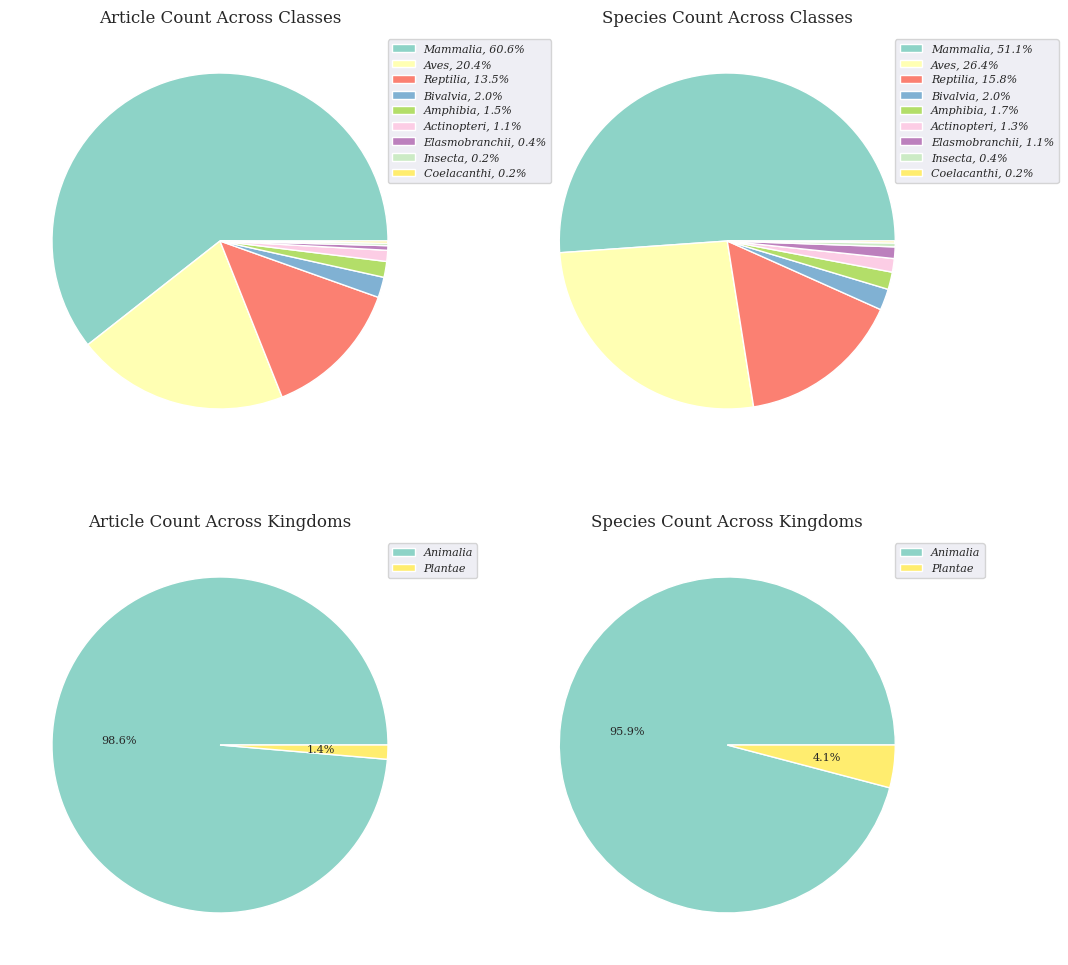

In [118]:
import seaborn as sns
import matplotlib.font_manager as font_manager
import matplotlib.ticker as ticker

sns.set_style("darkgrid")

df_media["COUNTER"] = 1

# Initialise the subplot function using number of rows and columns
figure, axs = plt.subplots(2, 2)

# Define fontstyle for labels
label_font = {'family': 'serif',
              'size': 8,
              'weight': 'normal'}

# Article share by Class
df_media.groupby('Class')['COUNTER'].sum().sort_values(ascending = False).plot(ax = axs[0,0], kind = 'pie', 
                                           #autopct="%1.1f%%", 
                                           figsize = (12,12), 
                                           #fontsize = 0,
                                           labels=None,
                                           #textprops=label_font,
                                           cmap = "Set3"
                                                )

axs[0,0].set_title("Article Count Across Classes", family = "Serif")
# Delete unneccessary y labels
axs[0,0].set_ylabel('')

# Species count by Class
class_share['Class'].value_counts().sort_values(ascending = False).plot(ax = axs[0,1], kind = 'pie', 
                                           #autopct="%1.1f%%", 
                                           figsize = (12,12), 
                                           #fontsize = 0,
                                           labels=None,
                                           #textprops=label_font,
                                           cmap = "Set3"
                                                )
axs[0,1].set_title("Species Count Across Classes", family = "Serif")
# Delete unneccessary y labels
axs[0,1].set_ylabel('')


# Article share by Kingdom
df_media.groupby('Kingdom')['COUNTER'].sum().sort_values(ascending = False).plot(ax = axs[1,0], kind = 'pie', 
                                           autopct="%1.1f%%", 
                                           figsize = (12,12), 
                                           fontsize = 8,
                                           labels=None,
                                           textprops=label_font,
                                           cmap = "Set3"
                                                )

axs[1,0].set_title("Article Count Across Kingdoms", family = "Serif")
# Delete unneccessary y labels
axs[1,0].set_ylabel('')

# Species count by Kingdom
kingdom_share['Kingdom'].value_counts().sort_values(ascending = False).plot(ax = axs[1,1], kind = 'pie', 
                                           autopct="%1.1f%%", 
                                           figsize = (12,12), 
                                           fontsize = 8,
                                           labels=None,
                                           textprops=label_font,
                                           cmap = "Set3"
                                                )
axs[1,1].set_title("Species Count Across Kingdoms", family = "Serif")
# Delete unneccessary y labels
axs[1,1].set_ylabel('')

# class labels
classlabels=list(class_share['Class'].value_counts().sort_values(ascending = False).reset_index()['index'])
# Species count
values=np.array(class_share['Class'].value_counts().sort_values(ascending = False))
percents = 100.*values/values.sum()
#Article count
artvalues = np.array(df_media.groupby('Class')['COUNTER'].sum().sort_values(ascending = False))
artpercents = 100.*artvalues/artvalues.sum()

# Define font
font = font_manager.FontProperties(family='Serif',
                                  weight='regular',
                                  style='italic', size=8)

# Create legend for pie charts
# use a list comprehension to update the labels
s = [f'{l}, {s:0.1f}%' for l, s in zip(classlabels, percents)]
a = [f'{l}, {s:0.1f}%' for l, s in zip(classlabels, artpercents)]

axs[0,0].legend(a, bbox_to_anchor=(0.9, 0.98), loc='upper left', borderaxespad=0, prop=font)
axs[0,1].legend(s, bbox_to_anchor=(0.9, 0.98), loc='upper left', borderaxespad=0, prop=font)
axs[1,0].legend(kingdomlabels, bbox_to_anchor=(0.9, 0.98), loc='upper left', borderaxespad=0, prop=font)
axs[1,1].legend(kingdomlabels, bbox_to_anchor=(0.9, 0.98), loc='upper left', borderaxespad=0, prop=font)

figure.savefig("images/classshares.png")

In [89]:
test = test.fillna(np.nan).replace([np.nan], ["null"])

In [95]:
import plotly.express as px

fig = px.treemap(test, path=[px.Constant("Kingdom"), 'Kingdom', 'Class', 'Order'], 
                 values= "COUNTER", 
                 color='Class', 
                 width = 2500, 
                 height = 1700
                )
fig.update_traces(root_color="lightgrey", pathbar_textfont_size=125)
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))

fig.write_image("images/fig4.png")

In [ ]:
# Group dataframe by the Class that remains consistent for all rows 
grouped_c = df_media.groupby('Class')

# Calculate the totals of the Classes
article_totals_c = grouped_c.value_counts().sum().round()


# What Class is being reported on the most? 
# Create a simple pie graph displaying the amt of articles per species 
ax = article_totals_c.plot.bar(figsize = (20,20), autopct="%1.1f%%", fontsize = 12, rotatelabels=True)

ax.set_ylabel('Article Amount', labelpad = 35, fontsize=20)
ax.set_title('Class Share in Dataset', pad = 35, fontsize = 30)

### Charismatic species processing

In [6]:
df['Charisma'] = 0

# Loop through the species and create a binary classification for species that are charismatic or not
for x in df['scientific_name']:
    if x in list(charismatic['scientific_name']):
        df.loc[df['scientific_name'] == x, 'Charisma'] = 1

In [8]:
# Do the same for the entire dataframe
rizz = df.merge(charismatic, on = 'scientific_name', how = 'inner')
#dg = df.merge(edge, on = 'scientific_name', how = 'inner')

In [9]:
# Group dataframe by the scientific name that remains consistent for all rows 
rz_grouped = rizz.groupby('General ID name')# 'Class', 'iucn_status'])

# Calculate the totals of the group species
article_totals_rz = rz_grouped.article_amt.sum().round()

#article_totals_rz.nlargest(20)

# Group dataframe by the scientific name that remains consistent for all rows 
rz_grouped = rizz.groupby('scientific_name')# 'Class', 'iucn_status'])

# Calculate the totals of the group species
article_totals_rz = rz_grouped.article_amt.sum().round()

#article_totals_rz.nlargest(20)

General ID name
Whale         542
Bear          531
Crocodile     463
Rhinoceros    353
Dolphin       206
Gorilla       173
Elephant      151
Lion          138
Wolf          127
Tiger         102
Panther        95
Shark          53
Cheetah        52
Zebra          45
Chimpanzee     44
Panda          33
Name: article_amt, dtype: int64

In [ ]:
test = pd.merge(species,df[['scientific_name','common_name']],on='scientific_name', how='left').drop_duplicates()
test['scientific_name'].nunique()

In [6]:
test.to_csv("csv/speciesinfo_commonnames.csv", sep = ";", index = False)

NameError: name 'test' is not defined

In [10]:
# Explode the articles column
s = rizz['articles'].map(dict.values).explode()
# NaN values need to be droppped
s = s.dropna()
# Drop the column articles and join the exploded values to the dataframe
rizz_articles = rizz.drop(columns=['articles']).join(pd.DataFrame([*s], s.index))



# Processing for articles       
# keep only unique article instances
rizz_media = rizz_articles.drop_duplicates(subset=['text'])
# Transform date column into DateTime
rizz_media["date"] = rizz_media["date"].apply(pd.to_datetime)
# Sort by oldest to newest
rizz_media = rizz_media.sort_values(by="date")

In [12]:
rizz_media = rizz_media.drop(columns=['Unnamed: 8', 'article_amt'])
rizz_media.reset_index(drop = True, inplace = True)
rizz_media = rizz_media[rizz_media['text'].notna()]
#rizz_media.to_csv("full_rizz.csv", sep = ";", index = False)

In [13]:
# A new analysis of article amounts per species after text duplicates have been removed
rz_group = rizz_media.groupby('scientific_name')
totalz = rz_group.sum().round()
speciestop = totalz['Count'].nlargest(20)

rz_group = rizz_media.groupby('General ID name')
totalz = rz_group.sum().round()
general_IDtop = totalz['Count'].nlargest(20)

/tmp/ipykernel_44/1718699019.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  totalz = rz_group.sum().round()
/tmp/ipykernel_44/1718699019.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  totalz = rz_group.sum().round()


In [42]:
rizz_media['COUNTER'] =1       #initially, set that counter to 1.
group_data = rizz_media.groupby(['General ID name', 'Class_y','scientific_name'])['COUNTER'].sum() #sum function
test = group_data.nlargest(20).reset_index()

General ID name  Class_y  scientific_name         
Bear             Mammal   Helarctos malayanus          67
                          Melursus ursinus             35
                          Tremarctos ornatus           67
                          Ursus arctos                 66
                          Ursus arctos isabellinus     39
                                                     ... 
Whale            Mammal   Eubalaena japonica           19
                          Hyperoodon ampullatus        33
                          Physeter macrocephalus       26
Wolf             Mammal   Canis lupus                 124
Zebra            Mammal   Equus grevyi                 42
Name: COUNTER, Length: 64, dtype: int64


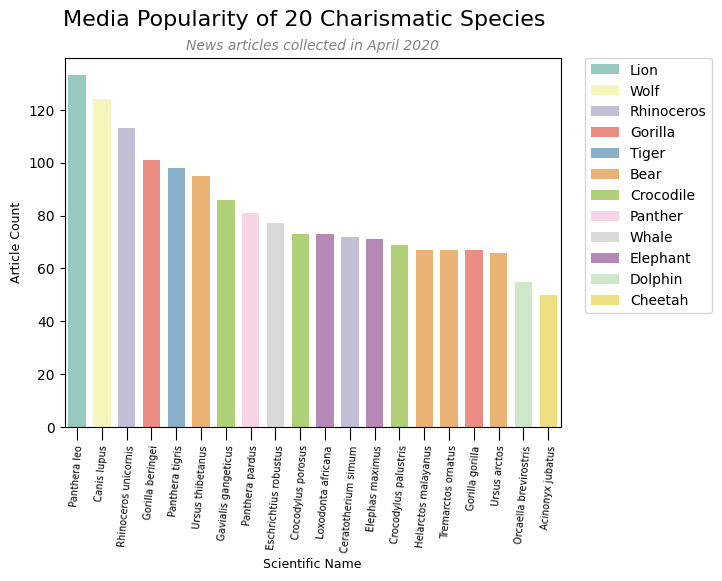

In [104]:
import seaborn as sns

ax = sns.barplot(
    x = 'scientific_name',
    y = 'COUNTER',
    hue = 'General ID name',
    data = test, 
    width = 0.7, palette = 'Set3', dodge = False
)
ax.set_xlabel('Scientific Name', fontsize=9)
ax.set_ylabel('Article Count', fontsize=9)


# Add suptitle above the title
plt.suptitle("Media Popularity of 20 Charismatic Species\n", fontsize=16)

# Add title
#ax.title("Realized by the Python Graph Gallery", color="grey", style='italic')
ax.set_title('News articles collected in April 2020', fontsize = 10, color="grey", style='italic')


ax.tick_params(axis='x', rotation=85, length = 9, labelsize = 7, left = True)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.savefig('top_20_species.png', bbox_inches = 'tight')

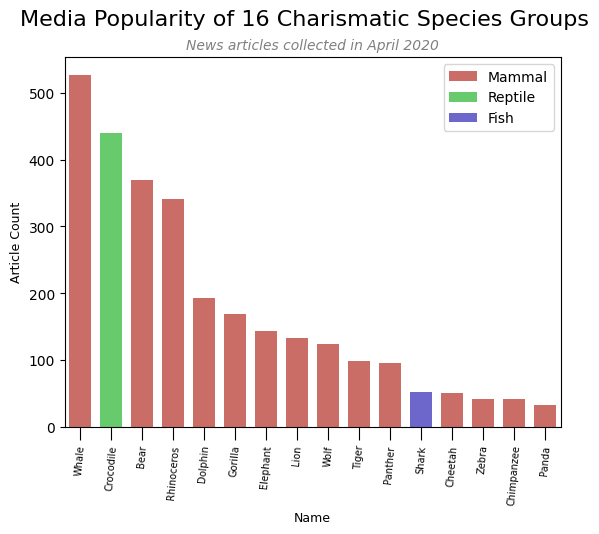

In [105]:
genid = rizz_media.groupby(['Class_y','General ID name'])['COUNTER'].sum() #sum function
genid = genid.nlargest(20).reset_index()

ax = sns.barplot(
    x = 'General ID name',
    y = 'COUNTER',
    hue = 'Class_y',
    data = genid, 
    width = 0.7, palette = 'hls', dodge = False
)
ax.set_xlabel('Name', fontsize=9)
ax.set_ylabel('Article Count', fontsize=9)


# Add suptitle above the title
plt.suptitle("Media Popularity of 16 Charismatic Species Groups\n", fontsize=16)

# Add title
#ax.title("Realized by the Python Graph Gallery", color="grey", style='italic')
ax.set_title('News articles collected in April 2020', fontsize = 10, color="grey", style='italic')


ax.tick_params(axis='x', rotation=85, length = 9, labelsize = 7, left = True)
ax.legend()#bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0
plt.savefig('top_16_gen_species.png', bbox_inches = 'tight')

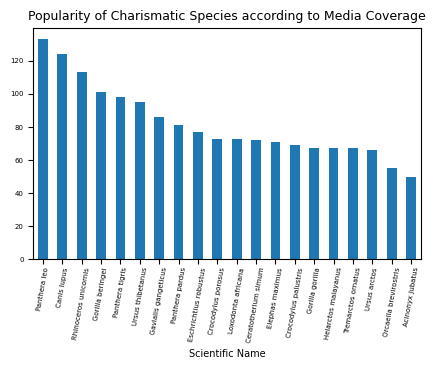

In [14]:
# What Charismatic species are given the most coverage?
# Create a simple bar graph displaying the amt of articles per species 
        
ax = speciestop.plot.bar(figsize = (5,3), fontsize = 5)
ax.set_xlabel('Scientific Name', fontsize=7)
ax.set_title('Popularity of Charismatic Species according to Media Coverage', fontsize = 9)
ax.tick_params(axis='x', rotation=80, left = True, pad = 2)
#plt.savefig('top_20_species.png', bbox_inches = 'tight')

In [10]:
simplified_beginning = df.groupby(["scientific_name", "Class"])['article_amt'].sum()

In [27]:
simpl = simplified_beginning.reset_index().groupby("Class").sum().sort_values(by='article_amt', ascending=False)

/tmp/ipykernel_72/2953391151.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  simpl = simplified_beginning.reset_index().groupby("Class").sum().sort_values(by='article_amt', ascending=False)


In [34]:
simpl = simpl.reset_index()

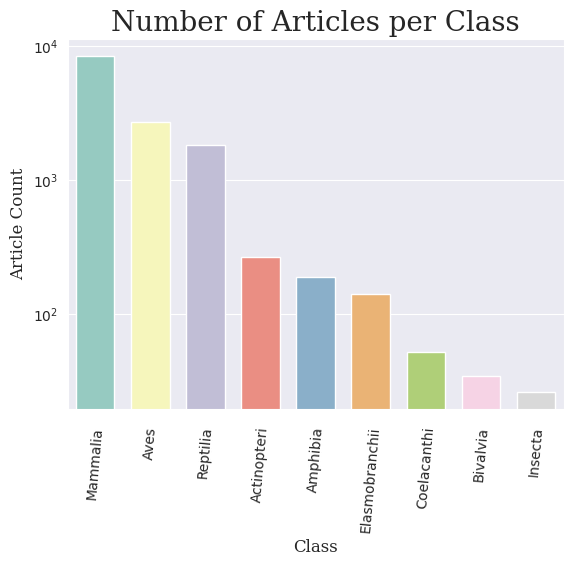

In [41]:
import matplotlib.font_manager as font_manager
import matplotlib.ticker as ticker
import seaborn as sns

sns.set_style("darkgrid")

ax = sns.barplot(
    x = 'Class',
    y = 'article_amt',
    #hue = 'Class',
    data = simpl, 
    width = 0.7, palette = 'Set3', dodge = False
)


# Add necessary titles and labels
ax.set_xlabel('Class', fontsize=12, family = "Serif")
ax.set_ylabel('Article Count', fontsize=12, family = "Serif")
ax.set_yscale('log')
ax.set_title('Number of Articles per Class', fontsize = 20, family = 'Serif')
ax.tick_params(axis='x', rotation=85, length = 9, labelsize = 10, left = True)


plt.savefig('figures/Class_share_articles_cnt.png', bbox_inches = 'tight')

# Stats and Correlations?

### Stats tests

In [3]:
df = pd.read_csv("articles-w-full_sharecount.csv", sep = ';')

#glhits = pd.read_csv("csv/google_hits_species.csv", sep = ';')

In [8]:
df['text'][0]

'TEMPO.CO, Jakarta - Holding a huge appeal for international tourists, the Indonesian province of Lampung is intensively promoting its tourism sector to help achieve sustainable development and to reduce poverty.\n\nThe province is endowed with several natural and marine tourist attractions with many white sandy beaches, pristine waterfalls, lush nature preserves, and much more for both local and international tourists to enjoy.\n\nAmong many districts in the province, East Lampung is a rich, beautiful and interesting area with friendly people and a lot of tourist attractions.\n\nAttempting to attract even more tourists, the district government, through the local Culture and Tourism Office, is making every effort to develop numerous natural, marine and cultural tourist attractions.\n\nThe many tourist attractions in East Lampung include the Way Kambas National Park, Pugung Raharjo Archaeological Park, Kerang Mas beach, Lake Kemuning, Lake Beringin, agro tourism and cultural tourism.\n\

In [5]:
df.to_csv("articles-w-full_sharecount.csv", sep = '~', index = False)

In [3]:
df['COUNTER'] =1       #initially, set that counter to 1.
group_data = df.groupby(['scientific_name'])[['sharecount', 'COUNTER']].sum() #sum function
test = group_data.reset_index()

In [4]:
speciesinfo = test.merge(glhits, on = 'scientific_name', how = 'inner')

In [5]:
speciesinfo = speciesinfo.rename(columns = {'COUNTER': 'article_cnt'})
speciesinfo = speciesinfo.sort_values(by = ["sharecount"], ascending=False).reset_index(drop = True)

In [17]:
speciesinfo.to_csv("csv/speciesinfo.csv", sep = ";", index = False)

In [16]:
## Detecting and removing outliers for glhits and sharecount
import sklearn

''' Detection '''
# IQR
Q1 = np.percentile(speciesinfo['sharecount'], 25,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(speciesinfo['sharecount'], 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1
 
print("Old Shape: ", speciesinfo.shape)
 
# Upper bound
upper=Q3+1.5*IQR
upper_array=np.array(speciesinfo['sharecount']>=upper)
# Lower bound
lower=Q1-1.5*IQR
lower_array=np.array(speciesinfo['sharecount']<=lower)
# Removing the outliers
print(upper_array[0])
print(lower_array[0])
#df_boston.drop(upper_array[0],inplace=True)
#df_boston.drop(lower_array[0],inplace=True)

Old Shape:  (566, 14)
True
False


/tmp/ipykernel_192/555865361.py:6: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q1 = np.percentile(speciesinfo['sharecount'], 25,
/tmp/ipykernel_192/555865361.py:9: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q3 = np.percentile(speciesinfo['sharecount'], 75,


In [13]:
from scipy import stats
import numpy as np
 
z = np.abs(stats.zscore(speciesinfo['gl_hits']))

threshold = 3
 
# Position of the outlier
print(np.where(z > 3))

(array([ 9, 11, 13, 41, 42, 44, 46, 48, 87, 97]),)


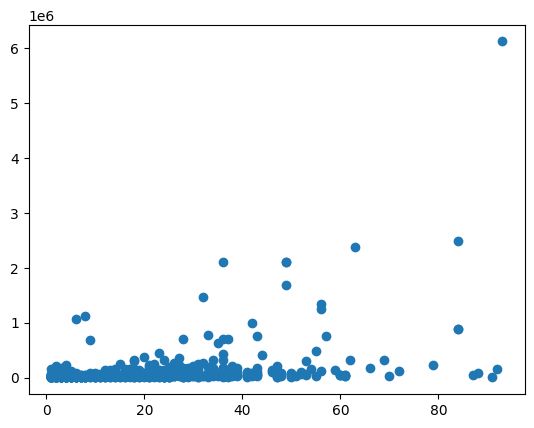

In [9]:
plt.scatter(speciesinfo['article_cnt'], speciesinfo['gl_hits'])
plt.show()

In [105]:
df_media['COUNTER'] =1       #initially, set that counter to 1.
group_data = df_media.groupby(['Charisma', 'scientific_name'])['COUNTER'].sum() #sum function
test_c = group_data.reset_index()

In [10]:
bland = test_c.loc[test_c['Charisma'] == 0].sample(n = 64)
rizz = test_c.loc[test_c['Charisma'] == 1]

sample = pd.concat([bland, rizz])

sample

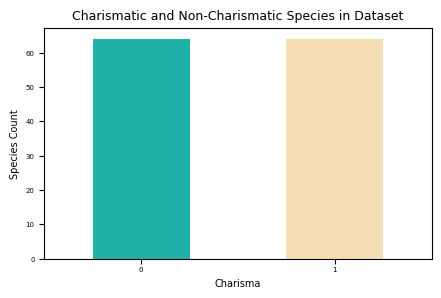

In [13]:
#df['COUNTER'] =1       #initially, set that counter to 1.
grouped = sample.groupby(['Charisma']) 
# Calculate the totals of the group species
charisma = grouped.scientific_name.nunique()


ax = charisma.plot.bar(figsize = (5,3), fontsize = 5, color = ['lightseagreen', 'wheat'])
ax.set_xlabel('Charisma', fontsize=7)
ax.set_ylabel('Species Count', fontsize=7)
ax.set_title('Charismatic and Non-Charismatic Species in Dataset', fontsize = 9)
ax.tick_params(axis='x', rotation=0, left = True, pad = 2)

In [102]:
test['Mammal'] = 0

for x in test['Class']:
    if x == 'Mammalia':
        test.loc[test['Class'] == x, 'Mammal'] = 1


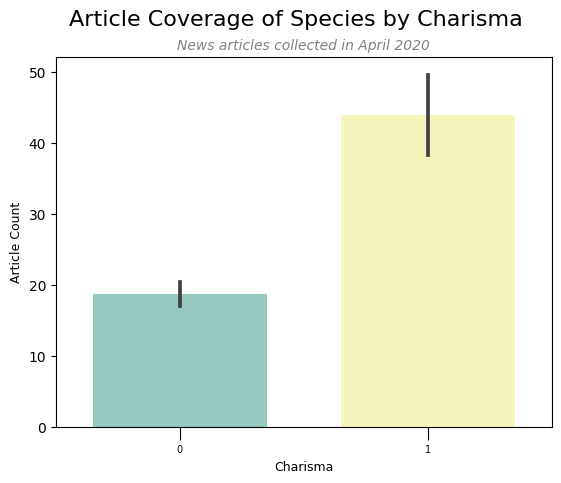

In [107]:
## INACCURATE VISUALIZATION

import seaborn as sns

ax = sns.barplot(
    x = 'Charisma',
    y = 'COUNTER',
    #hue = 'Charisma',
    data = test_c, 
    width = 0.7, palette = 'Set3'
    #dodge = False
)
ax.set_xlabel('Charisma', fontsize=9)
ax.set_ylabel('Article Count', fontsize=9)


# Add suptitle above the title
plt.suptitle("Article Coverage of Species by Charisma\n", fontsize=16)

# Add title
#ax.title("Realized by the Python Graph Gallery", color="grey", style='italic')
ax.set_title('News articles collected in April 2020', fontsize = 10, color="grey", style='italic')


ax.tick_params(axis='x', rotation=0, length = 9, labelsize = 7, left = True)
#legend = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
#legend.set_title("Charismatic")
#for t, l in zip(legend.texts,("No", "Yes")):
    #t.set_text(l)
#plt.savefig('figures/rizz_article_total.png', bbox_inches = 'tight')

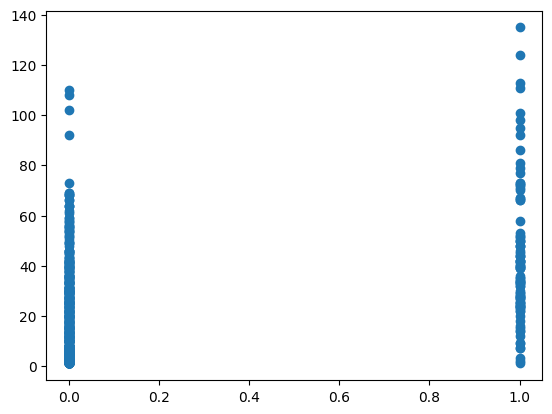

In [108]:
plt.scatter(test_c['Charisma'], test_c['COUNTER'])
plt.show()

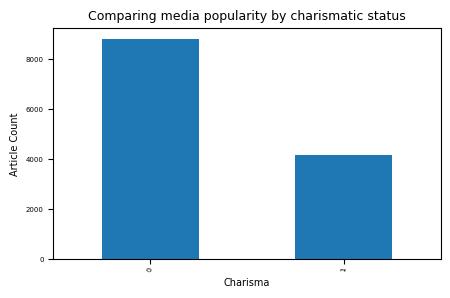

In [109]:
# A new analysis of article amounts per species after text duplicates have been removed
totalz = test_c.groupby('Charisma').sum('COUNTER').round()
#totalz = rz_group.sum().round()
#speciestop = totalz['Count'].nlargest(20)
ax = totalz['COUNTER'].plot.bar(figsize = (5,3), fontsize = 5)
ax.set_xlabel('Charisma', fontsize=7)
ax.set_ylabel('Article Count', fontsize=7)
ax.set_title('Comparing media popularity by charismatic status', fontsize = 9)
ax.tick_params(axis='x', rotation=80, left = True, pad = 2)

In [110]:
from scipy.stats import spearmanr

#calculate Spearman Rank correlation and corresponding p-value
rho, p = spearmanr(test_c['Charisma'], test_c['COUNTER'])

#print Spearman rank correlation and p-value
print(rho)
print(p)

0.38254437370552674
3.945637273263562e-21


### Impact and visualization of Classifications 

In [15]:
df_media['COUNTER'] =1       #initially, set that counter to 1.
group_data = df_media.groupby(['Family'])['COUNTER'].sum() #sum function
test = group_data.nlargest(20).reset_index()

In [16]:
test

,Family,COUNTER
0,Felidae,1015
1,Psittacidae,669
2,Bovidae,574
3,Cercopithecidae,536
4,Crocodylidae,401
5,Ursidae,401
6,Hominidae,358
7,Manidae,358
8,Rhinocerotidae,341
9,Testudinidae,287


### Temporal Analysis and Troubleshooting

In [19]:
df_media['date']

0       1970-01-01
1       1970-01-01
2       1970-01-01
3       1970-01-01
4       1970-01-01
           ...    
12977   2020-05-31
12978   2020-05-31
12979   2020-05-31
12980   2020-06-01
12981   2020-12-30
Name: date, Length: 12982, dtype: datetime64[ns]

In [ ]:
# Some re-processing
df_full = df_full.drop_duplicates(subset=['text'])
df_full.reset_index(drop = True, inplace = True)

# Transform date column into DateTime
df_full["datetime"] = df_full["date"].apply(pd.to_datetime)
# Sort by oldest to newest
df_full = df_full.sort_values(by="datetime")

In [57]:
# fix 1970 dates
sample = df_full.loc[df_full['date'].isin(['01/01/1970'])]


# replacing the dates 1970 with the dates found in the image link as they match the date the article was published
date = []
for s in sample['image']:
    result = re.search('data/(.*)/id_', s)
    date.append(result.group(1))
    
    
# Conactenate
pd.concat([sample, pd.DataFrame({'dates':date})], axis=1)